Коллокация - устойчивое сочетание

Mepa t-score также учитывает частоту совместной встречаемости ключевого слова и его коллоката, отвечая на вопрос, насколько не случай-ной является сила ассоциации (связанности) между коллокатами:


In [ ]:
import pandas as pd
import regex as re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict
import math
nltk.download('stopwords')



sentences = list()
sentence = list()
with open('/content/annotations.tsv') as file:
  for line in file:
      if line != "\n":
        sentence.append(line.split('\t')[1])
      if line == "\n" and sentence:
        sentences.append(sentence)
        sentence = list()
print(sentences)

удаляем символы, приводим к нижнем урегистру , используем стоп слово


In [ ]:
stop_words = set(stopwords.words('english'))
clear_data = []

import re

def clean_sentence(sentence):
    cleaned = []
    for lemma in sentence:
        cleaned_tek = re.sub(r"(?<!\w)\.(?!\w)|[^\w\s@._-]+", "", lemma.lower())
        if cleaned_tek and cleaned_tek not in stop_words:
            cleaned.append(cleaned_tek)
    return cleaned
for sentence in sentences:
    clear_data.append(clean_sentence(sentence))

In [ ]:
trigrams = list()
for sentence in clear_data:
    for i in range(len(sentence) - 2):
        trigrams.append(sentence[i:i+3])


In [ ]:
#считаем частоты

trigram_frequencie = dict()
for trigram in trigrams:
    if tuple(trigram) not in trigram_frequencie:
        trigram_frequencie[tuple(trigram)] = 1
    else:
        trigram_frequencie[tuple(trigram)] += 1


In [ ]:

def t_score(trigram_frequencies, word_counts, uniq_words):
    tscores = {}
    for trigram, count in trigram_frequencies.items():
        expected_frequency = (word_counts[trigram[0]] / uniq_words) * (word_counts[trigram[1]] / uniq_words) *(word_counts[trigram[2]] / uniq_words) / uniq_words
        tscore = (count - expected_frequency) / math.sqrt(count)

        tscores[trigram] = tscore
    return tscores

In [ ]:
from collections import Counter

words_count = Counter()

for sentence in clear_data:
    words_count.update(sentence)  #сколько раз встречается слово

uniq_words_total = sum(words_count.values()) #колво уникальных слов

t_scores = t_score(trigram_frequencie, words_count, uniq_words_total)

In [ ]:
sorted(t_scores.items(), key=lambda x: x[1], reverse=True)[:30]

In [ ]:
import nltk
from nltk.collocations import *
from nltk.corpus import PlaintextCorpusReader

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()



trigram_measures = nltk.collocations.TrigramAssocMeasures()

flat_list = [item for sublist in clear_data for item in sublist]
finder_thr = TrigramCollocationFinder.from_words(flat_list)
print(finder_thr.nbest(trigram_measures.student_t, 30))

[('task', 'force', 'usa'), ('bosnia', 'task', 'force'), ('typical', 'visible', 'light'), ('front', 'white', 'house'), ('may', '15', '93'), ('leads', 'series', '20'), ('nhl', 'playoff', 'results'), ('siap', 'sistemi', 'p'), ('hstarke@europa.eng.gtefsd.com', 'hal', 'starke'), ('sandvik@newton.apple.com', 'kent', 'sandvik'), ('george', 'howell', 'goucher@wb3ffv.ampr.org'), ('goucher@wb3ffv.ampr.org', 'george', 'howell'), ('howell', 'goucher@wb3ffv.ampr.org', 'george'), ('period', 'lak', 'carson'), ('saturday', 'may', '15'), ('visible', 'light', 'led'), ('distribution', 'world', 'replyto'), ('organization', 'sun', 'microsystems'), ('6', 'shots', 'goal'), ('sun', 'microsystems', 'lines'), ('edu', 'organization', 'university'), ('edu', 'lines', '22'), ('series', '20', '1'), ('0', '0', '0'), ('0', '1', '1'), ('1', '1', '2'), ('0584', '82', 'honda'), ('07', 'hp', 'vue'), ('1542b', 'bios', 'enabled'), ('1993apr24.165727.8899@ra.royalroads.ca', 'mlee@post.royalroads.ca', 'malcolm')]


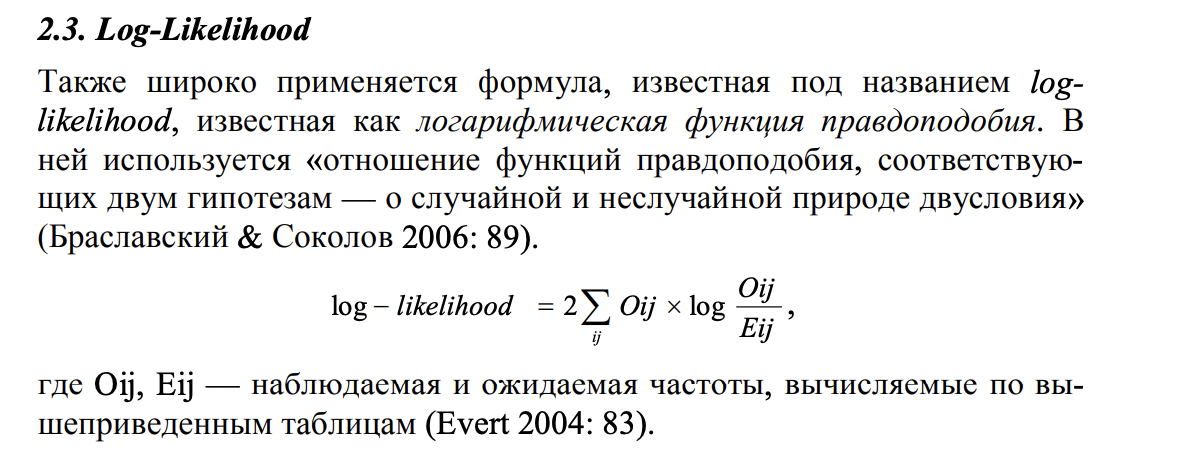

In [ ]:
import numpy as np
import math

def calculate_matrices(trigram_frequencies, word_counts, total_words):
    # Получаем список уникальных слов
    unique_words = list(word_counts.keys())
    n = len(unique_words)

    # Инициализация матрицы частот
    observed_matrix = np.zeros((n, n, n))
    expected_matrix = np.zeros((n, n, n))

    # Заполнение наблюдаемой матрицы
    for trigram, count in trigram_frequencies.items():
        i = unique_words.index(trigram[0])
        j = unique_words.index(trigram[1])
        k = unique_words.index(trigram[2])
        observed_matrix[i, j, k] = count

    # Заполнение ожидаемой матрицы
    for i in range(n):
        for j in range(n):
            for k in range(n):
                expected_frequency = (
                    (word_counts[unique_words[i]] / total_words) *
                    (word_counts[unique_words[j]] / total_words) *
                    (word_counts[unique_words[k]] / total_words) *
                    total_words
                )
                print(expected_frequency)
                expected_matrix[i, j, k] = expected_frequency

    return observed_matrix, expected_matrix

def log_likelihood(observed_matrix, expected_matrix):
    ll_scores = 0
    for i in range(observed_matrix.shape[0]):
        for j in range(observed_matrix.shape[1]):
            for k in range(observed_matrix.shape[2]):
                O = observed_matrix[i, j, k]
                E = expected_matrix[i, j, k]
                if O > 0 and E > 0:
                    ll_scores += O * math.log(O / E)
    return 2 * ll_scores

# Пример использования
observed_matrix, expected_matrix = calculate_matrices(trigram_frequencie, words_count, uniq_words_total)
ll_score = log_likelihood(observed_matrix, expected_matrix)
print(ll_score)